In [95]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

In [96]:
def parse_data_file(filename):
    # Чтение файла и парсинг данных по каналам без сохранения во временные csv
    with open(filename, "r") as raw_data:
        channel_data = {}
        headers = {}
        channel_order = []
        while True:
            line = raw_data.readline()
            if not line:
                break
            if line.startswith("#CHANNEL"):
                ch = line.split(":")[1].strip()
                channel_order.append(ch)
                size_line = raw_data.readline()
                size = int(size_line.strip().split('=')[1])
                header_line = raw_data.readline().strip().split(",")
                headers[ch] = header_line
                channel_data[ch] = []
                for i in range(size):
                    data_line = raw_data.readline().strip().split(",")
                    channel_data[ch].append(data_line)
    # Преобразуем данные каналов в DataFrame
    dfs = {}
    for ch in channel_order:
        dfs[ch] = pd.DataFrame(channel_data[ch], columns=headers[ch])
        for col in dfs[ch].columns:
            dfs[ch][col] = pd.to_numeric(dfs[ch][col], errors='coerce')
    # Собираем итоговый DataFrame
    data = pd.DataFrame()
    # Предполагаем, что первый канал содержит время
    time_col = None
    for col in dfs[channel_order[0]].columns:
        if "Time" in col:
            time_col = col
            break
    if time_col is None:
        raise ValueError("Не найден столбец времени в первом канале")
    data["Time, s"] = dfs[channel_order[0]][time_col]
    # Добавляем все каналы
    for idx, ch in enumerate(channel_order):
        volt_col = None
        for col in dfs[ch].columns:
            if "Volt" in col:
                volt_col = col
                break
        if volt_col is not None:
            data[f"V_{idx+1}"] = dfs[ch][volt_col]
    return data


In [97]:
data = parse_data_file("data41ma_new.txt")
data

,"Time, s",V_1,V_2,V_3
0,0.000000,0.218,1.600,-1.28
1,0.000008,0.214,1.600,-1.36
2,0.000016,0.214,1.600,-1.28
3,0.000024,0.216,1.600,-1.44
4,0.000032,0.218,1.600,-1.44
...,...,...,...,...
3995,0.031960,0.160,1.120,2.40
3996,0.031968,0.160,1.120,2.32
3997,0.031976,0.160,1.120,2.40
3998,0.031984,0.160,1.120,2.48


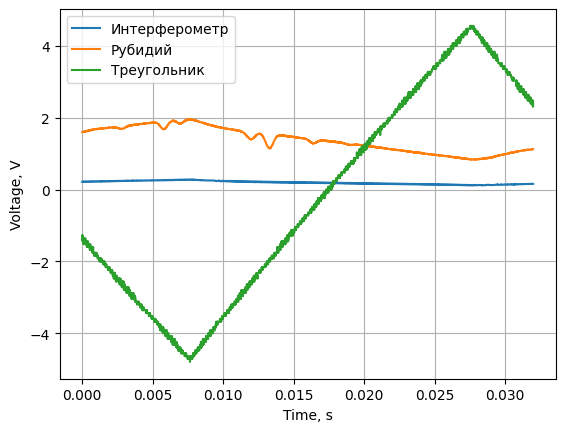

In [98]:

plt.plot(data["Time, s"], data["V_1"], label="Интерферометр")
plt.plot(data["Time, s"], data["V_2"], label="Рубидий")
plt.plot(data["Time, s"], data["V_3"], label="Треугольник")
plt.xlabel("Time, s")
plt.ylabel("Voltage, V")
plt.legend()
plt.grid()



74.9481145 MHz
208 
 [1.04 0.96 1.04 0.96 0.96]


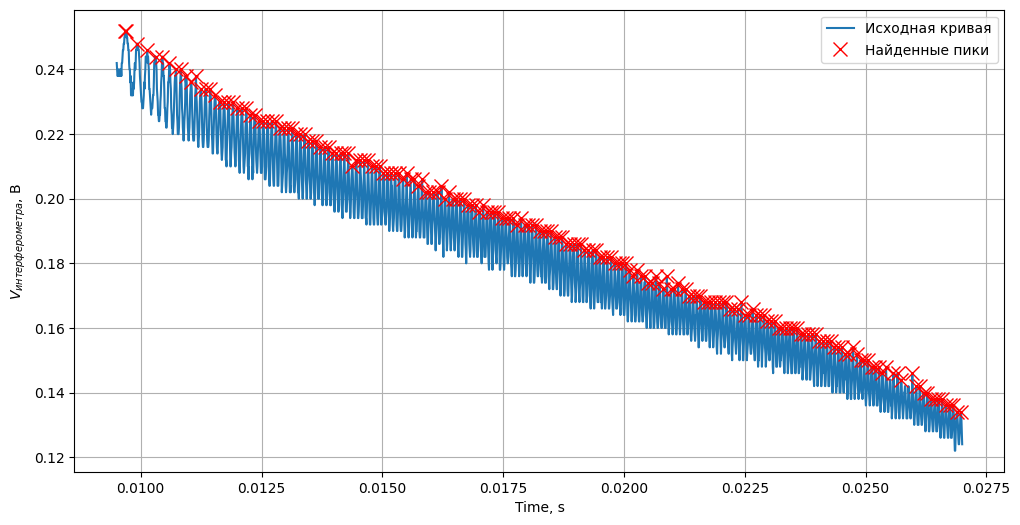

C:\Users\RedBrean\AppData\Local\Temp\ipykernel_15048\3496732355.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_data["nu"] = cut_data["Time, s"].apply(delta_nu)


In [99]:
c = 299792458
a = 1
dnu = c/(4*a)
print(dnu*1E-6, 'MHz') # частоты между пиками интерферометра

# Допустим, у нас есть массив y с значениями кривой
cut_data_wide = data[(data["Time, s"] >= 0.0095) & (data["Time, s"] <= 0.027)]
cut_data = data[(data["Time, s"] >= 0.0098) & (data["Time, s"] <= 0.025)]
x=cut_data_wide["Time, s"]
y=cut_data_wide["V_1"]
# Находим пики (локальные максимумы)
peaks, _ = sp.signal.find_peaks(np.array(y),   
    distance=3,          # минимум 50 точек между пиками
    prominence=0.01,       # минимальная "выдающаяся" высота
    width=1 )

# Визуализируем результат
plt.figure(figsize=(12, 6))
plt.plot(x, y, label='Исходная кривая')
plt.plot(np.array(x)[peaks], np.array(y)[peaks], "rx", markersize=10, label='Найденные пики')
peaksx = np.array(x)[peaks]
distances = peaksx*0
for i in range(len(peaksx)-1):
    distances[i] = peaksx[i+1]-peaksx[i]
print(len(distances),"\n",distances[10:15]*10000)
plt.legend()
plt.xlabel("Time, s")
plt.ylabel("$V_{интерферометра}$, В")
plt.grid(True)
plt.show()

def delta_nu(t):
    i = len(peaksx[peaksx<t])-1
    if i < 0 or i >= len(peaksx) - 1:
        raise ValueError("t вне диапазона пиков интерферометра")
    return dnu*(i + (t-peaksx[i])/(peaksx[i+1]-peaksx[i])) 

cut_data["nu"] = cut_data["Time, s"].apply(delta_nu)



<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_15048\39059975.py:3: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$\Delta \\nu$, Гц")


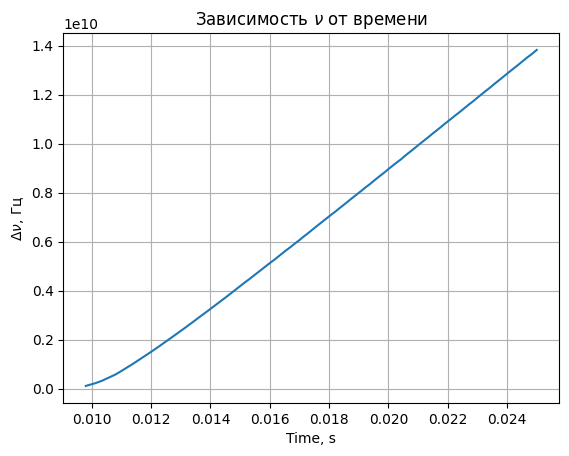

In [100]:
plt.plot(cut_data["Time, s"], cut_data["nu"])
plt.xlabel("Time, s")
plt.ylabel("$\Delta \\nu$, Гц")
plt.title("Зависимость $\\nu$ от времени")
plt.grid(True)
plt.show()


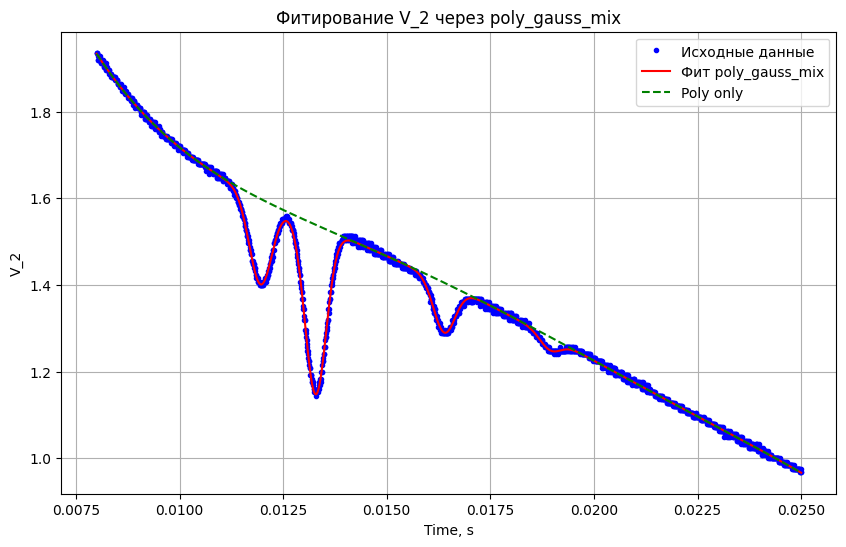

p[0] = -2199288422.2957244
p[1] = 209021357.78378582
p[2] = -7793951.2788507845
p[3] = 141860.70119790564
p[4] = -1302.8363608615684
p[5] = 6.483609243121209
p[6] = 0.12347073875081287
p[7] = 0.011953876836864335
p[8] = 0.00027006459419154756
p[9] = 0.2542590674576073
p[10] = 0.013283713443595536
p[11] = 0.00025553302971804325
p[12] = 0.08187333771845659
p[13] = 0.016387492158381277
p[14] = 0.00026036726305799814
p[15] = 0.024081300495044127
p[16] = 0.018941782784082956
p[17] = 0.0002446426321528879
[-2.19928842e+09  2.09021358e+08 -7.79395128e+06  1.41860701e+05
 -1.30283636e+03  6.48360924e+00] [1.23470739e-01 1.19538768e-02 2.70064594e-04 2.54259067e-01
 1.32837134e-02 2.55533030e-04 8.18733377e-02 1.63874922e-02
 2.60367263e-04 2.40813005e-02 1.89417828e-02 2.44642632e-04]


In [101]:
cut_data_wide = data[(data["Time, s"] >= 0.008) & (data["Time, s"] <= 0.025)]

def poly_gauss_mix(x, *params):
    """
    params: [p0, p1, ..., pn, A1, mu1, sigma1, ..., A4, mu4, sigma4]
    p0...pn — коэффициенты многочлена степени n
    Ai, mui, sigmai — параметры 4 гауссиан
    """
    n = 4  # число гауссиан
    poly_deg = len(params) - n*3
    poly_coeffs = params[:poly_deg]
    gauss_params = params[poly_deg:]
    # Многочлен
    poly = np.polyval(poly_coeffs, x)
    # Сумма 4 гауссиан
    gauss_sum = 0
    for i in range(n):
        A = gauss_params[i*3]
        mu = gauss_params[i*3+1]
        sigma = gauss_params[i*3+2]
        gauss_sum += A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    return poly * (1-gauss_sum)



gauss_params = [0.1, 0.011, 0.0004,  # First Gaussian
                0.2, 0.013, 0.0004,
                0.1,0.016,0.0004,
                0.05,0.019,0.0004]  # Second Gaussian

x = cut_data_wide["Time, s"].values
y = cut_data_wide["V_2"].values

# Fit V_2 with a polynomial of degree 3
poly_params = np.polyfit(x, y, 1)
# Update initial_params with the fitted polynomial coefficients
initial_params = list(poly_params) + gauss_params

# Фитирование
popt_1, pcov = sp.optimize.curve_fit(poly_gauss_mix, x, y, p0=initial_params, maxfev=5000)
degree = 5
initial_params = [0]*(degree-1) + list(popt_1) # Добавляем степени многочлена
popt_2, pcov = sp.optimize.curve_fit(poly_gauss_mix, x, y, p0=initial_params, maxfev=5000)
poly_params = popt_2[:degree+1]
gauss_params = popt_2[degree+1:]
# Графики
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b.', label='Исходные данные')
plt.plot(x, poly_gauss_mix(x, *popt_2), 'r-', label='Фит poly_gauss_mix')
plt.xlabel("Time, s")
plt.ylabel("V_2")
plt.legend()
plt.grid(True)
plt.title("Фитирование V_2 через poly_gauss_mix")
plt.plot(x, np.polyval(poly_params, x), 'g--', label='Poly only')
plt.legend()
plt.show()
for i, coef in enumerate(popt_2):
    print(f"p[{i}] = {coef}")

print(poly_params, gauss_params)

<>:52: SyntaxWarning: invalid escape sequence '\D'
<>:52: SyntaxWarning: invalid escape sequence '\D'
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_15048\1861804965.py:52: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$\Delta \\nu$, МГц")


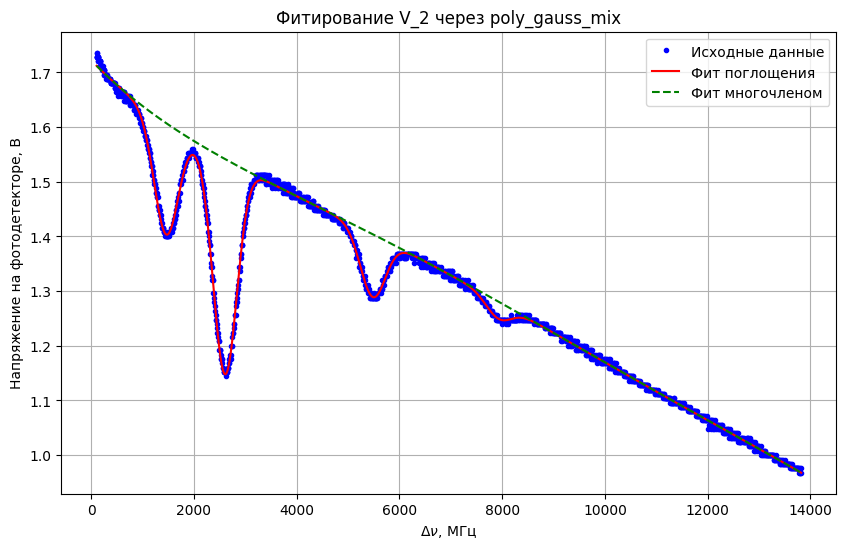

p[0] = -3.013064996280723e-51
p[1] = 1.3129446168305818e-40
p[2] = -2.1233380337139806e-30
p[3] = 1.5285752938579207e-20
p[4] = -9.69380609822097e-11
p[5] = 1.7222519505319343
p[6] = 0.1267240169005504
p[7] = 1460390829.5503254
p[8] = 233116278.15816757
p[9] = 0.2553743576904808
p[10] = 2605781892.311297
p[11] = 230114974.50700387
p[12] = 0.08179548544958397
p[13] = 5482351455.19837
p[14] = 241776444.07385913
p[15] = 0.02448039544649359
p[16] = 7931543605.919733
p[17] = 243426699.31175357
[-3.01306500e-51  1.31294462e-40 -2.12333803e-30  1.52857529e-20
 -9.69380610e-11  1.72225195e+00] [1.26724017e-01 1.46039083e+09 2.33116278e+08 2.55374358e-01
 2.60578189e+09 2.30114975e+08 8.17954854e-02 5.48235146e+09
 2.41776444e+08 2.44803954e-02 7.93154361e+09 2.43426699e+08]


In [102]:
cut_data

def poly_gauss_mix(x, *params):
    """
    params: [p0, p1, ..., pn, A1, mu1, sigma1, ..., A4, mu4, sigma4]
    p0...pn — коэффициенты многочлена степени n
    Ai, mui, sigmai — параметры 4 гауссиан
    """
    n = 4  # число гауссиан
    poly_deg = len(params) - n*3
    poly_coeffs = params[:poly_deg]
    gauss_params = params[poly_deg:]
    # Многочлен
    poly = np.polyval(poly_coeffs, x)
    # Сумма 4 гауссиан
    gauss_sum = 0
    for i in range(n):
        A = gauss_params[i*3]
        mu = gauss_params[i*3+1]
        sigma = gauss_params[i*3+2]
        gauss_sum += A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    return poly * (1-gauss_sum)



gauss_params = [0.13, 0.15e10, 200e6,  # First Gaussian
                0.2, 0.28e10, 200e6,
                0.1,0.55e10,200e6,
                0.05,0.8e10,200e6]  # Second Gaussian

x = cut_data["nu"].values
y = cut_data["V_2"].values

# Fit V_2 with a polynomial of degree 3
poly_params = np.polyfit(x, y, 1)
# Update initial_params with the fitted polynomial coefficients
initial_params = list(poly_params) + gauss_params

plt.figure(figsize=(10, 6))
plt.plot(x/10**6, y, 'b.', label='Исходные данные')

# Фитирование
popt_1, pcov = sp.optimize.curve_fit(poly_gauss_mix, x, y, p0=initial_params, maxfev=5000)
degree = 5
initial_params = [0]*(degree-1) + list(popt_1) # Добавляем степени многочлена
popt_2, pcov = sp.optimize.curve_fit(poly_gauss_mix, x, y, p0=initial_params, maxfev=5000)
poly_params = popt_2[:degree+1]
gauss_params = popt_2[degree+1:]
# Графики

plt.plot(x/10**6, poly_gauss_mix(x, *popt_2), 'r-', label='Фит поглощения')
plt.xlabel("$\Delta \\nu$, МГц")
plt.ylabel("Напряжение на фотодетекторе, В")
plt.legend()
plt.grid(True)
plt.title("Фитирование V_2 через poly_gauss_mix")
plt.plot(x/10**6, np.polyval(poly_params, x), 'g--', label='Фит многочленом')
plt.legend()
plt.show()
for i, coef in enumerate(popt_2):
    print(f"p[{i}] = {coef}")

print(poly_params, gauss_params)

Параметры гауссиан (A, mu, sigma):
Гауссиана 1: (np.float64(0.1267240169005504), np.float64(1460390829.5503254), np.float64(233116278.15816757))
Гауссиана 2: (np.float64(0.2553743576904808), np.float64(2605781892.311297), np.float64(230114974.50700387))
Гауссиана 3: (np.float64(0.08179548544958397), np.float64(5482351455.19837), np.float64(241776444.07385913))
Гауссиана 4: (np.float64(0.02448039544649359), np.float64(7931543605.919733), np.float64(243426699.31175357))


<>:27: SyntaxWarning: invalid escape sequence '\D'
<>:27: SyntaxWarning: invalid escape sequence '\D'
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_15048\1830427715.py:27: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$\Delta \\nu$, МГц")


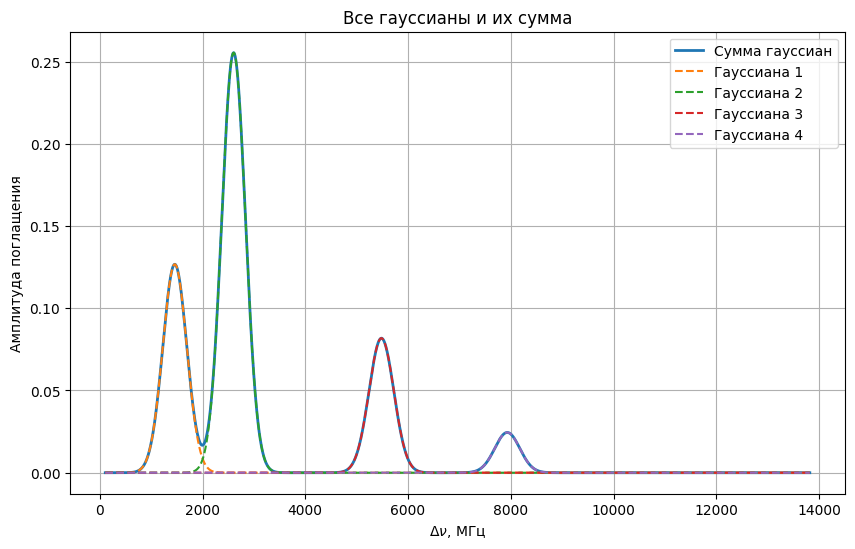

In [103]:
def sum_gaussians(x, gauss_params):
    n = len(gauss_params) // 3
    gauss_sum = np.zeros_like(x, dtype=float)
    gaussians = []
    for i in range(n):
        A = gauss_params[i*3]
        mu = gauss_params[i*3+1]
        sigma = gauss_params[i*3+2]
        g = A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
        gauss_sum += g
        gaussians.append(g)
        
    return gauss_sum, gaussians

gauss_params_tuples = [(gauss_params[i*3], gauss_params[i*3+1], gauss_params[i*3+2]) for i in range(len(gauss_params)//3)]
print("Параметры гауссиан (A, mu, sigma):")
for i, params in enumerate(gauss_params_tuples):
    print(f"Гауссиана {i+1}: {params}")



plt.figure(figsize=(10, 6))
total, gaussians = sum_gaussians(x, gauss_params)
plt.plot(x/10**6, total, label="Сумма гауссиан", linewidth=2)
for i, g in enumerate(gaussians):
    plt.plot(x/10**6, g, '--', label=f'Гауссиана {i+1}')
plt.xlabel("$\Delta \\nu$, МГц")
plt.ylabel("Амплитуда поглащения")
plt.title("Все гауссианы и их сумма")
plt.grid(True)
plt.legend()
plt.show()


In [104]:
add_nu_all = np.array([[194,-72,-230],[100,-20,-84],[-20,-84,-113],[-72,-74,-302]])
weights = np.array([[14/6,5/6,1/6],[81/27,35/27,10/27],[28/27,35/27,1],[5/6,5/6,2/6]])
add_nu_weighted = np.array([np.dot(add_nu_all[i],weights[i])/np.dot(weights[i],weights[i])**(0.5) for i in [0,1,2,3]])
nus_true = np.array([-2563,-1265,1770,4271])
nus_true_w = np.round(nus_true)# + add_nu_weighted,0)
print(nus_true_w[1]-nus_true_w[0],nus_true_w[2]-nus_true_w[1],nus_true_w[3]-nus_true_w[2],"MHz"," - таблица до весов")
nus_true_w = np.round(nus_true + add_nu_weighted,0)
print(nus_true_w[1]-nus_true_w[0],nus_true_w[2]-nus_true_w[1],nus_true_w[3]-nus_true_w[2],"MHz"," - таблица после весов")
print((gauss_params_tuples[1][1]-gauss_params_tuples[0][1])*1E-6,
      (gauss_params_tuples[2][1]-gauss_params_tuples[1][1])*1E-6,
      (gauss_params_tuples[3][1]-gauss_params_tuples[2][1])*1E-6, 'MHz'," - мы")
for i, (A, mu, sigma) in enumerate(gauss_params_tuples, 1):
      print(f"Пик поглащения {i}:")
      print(f"  Амплитуда (A): {A:.4g}")
      print(f"  Центр (mu): {mu/1e6:.2f} МГц")
      print(f"  Ширина (sigma): {sigma/1e6:.2f} МГц")
      print(f"  Доплеровское уширинеие (sigma): {2.355*sigma/1e6:.2f} МГц\n")


1298 3035 2501 MHz  - таблица до весов
1229.0 2836.0 2444.0 MHz  - таблица после весов
1145.3910627609714 2876.569562887073 2449.192150721363 MHz  - мы
Пик поглащения 1:
  Амплитуда (A): 0.1267
  Центр (mu): 1460.39 МГц
  Ширина (sigma): 233.12 МГц
  Доплеровское уширинеие (sigma): 548.99 МГц

Пик поглащения 2:
  Амплитуда (A): 0.2554
  Центр (mu): 2605.78 МГц
  Ширина (sigma): 230.11 МГц
  Доплеровское уширинеие (sigma): 541.92 МГц

Пик поглащения 3:
  Амплитуда (A): 0.0818
  Центр (mu): 5482.35 МГц
  Ширина (sigma): 241.78 МГц
  Доплеровское уширинеие (sigma): 569.38 МГц

Пик поглащения 4:
  Амплитуда (A): 0.02448
  Центр (mu): 7931.54 МГц
  Ширина (sigma): 243.43 МГц
  Доплеровское уширинеие (sigma): 573.27 МГц



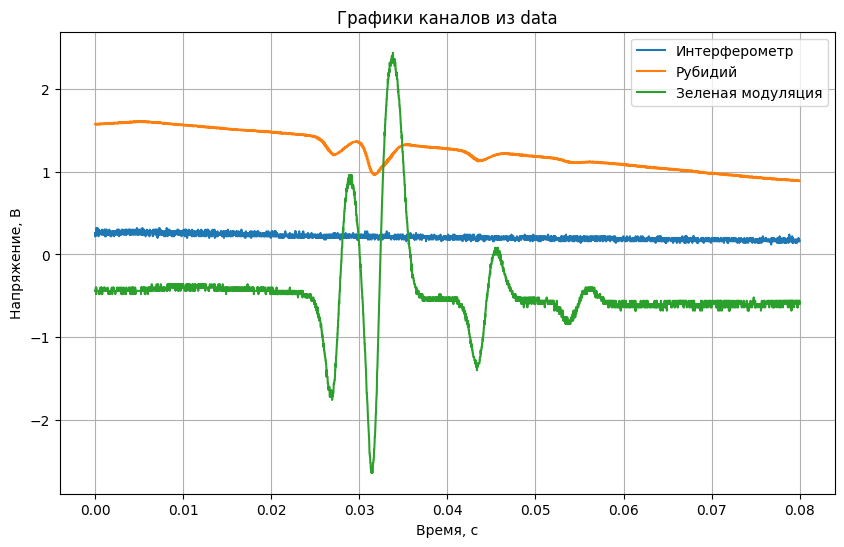

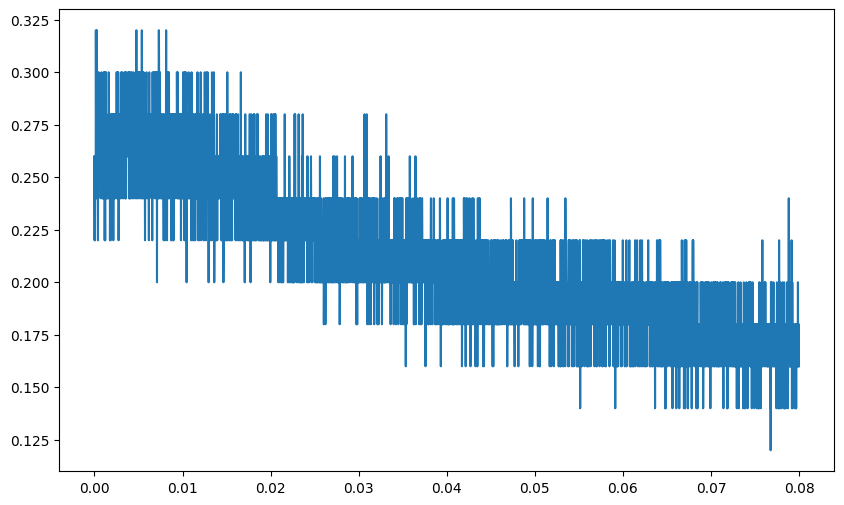

,"Time, s",V_1,V_2,V_3,V_4
0,0.00000,0.26,1.576,4.32,-0.44
1,0.00002,0.22,1.580,4.48,-0.44
2,0.00004,0.26,1.576,4.40,-0.44
3,0.00006,0.22,1.576,4.40,-0.44
4,0.00008,0.24,1.572,4.48,-0.44
...,...,...,...,...,...
3995,0.07990,0.16,0.888,-4.56,-0.60
3996,0.07992,0.16,0.896,-4.56,-0.56
3997,0.07994,0.18,0.896,-4.56,-0.60
3998,0.07996,0.18,0.896,-4.56,-0.56


In [105]:
data = parse_data_file("41_ma_with_green_mod_line.txt")
plt.figure(figsize=(10, 6))
plt.plot(data["Time, s"], data["V_1"], label="Интерферометр")
plt.plot(data["Time, s"], data["V_2"], label="Рубидий")
# plt.plot(data["Time, s"], data["V_3"], label="Треугольник")
if "V_4" in data.columns:
    plt.plot(data["Time, s"], data["V_4"], label="Зеленая модуляция")
plt.xlabel("Время, с")
plt.ylabel("Напряжение, В")
plt.legend()
plt.grid(True)
plt.title("Графики каналов из data")
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(data["Time, s"], data["V_1"], label="Интерферометр")
plt.show()

data

74.9481145 MHz
502 
 [1.4 0.6 1.4 1.2 0.6]


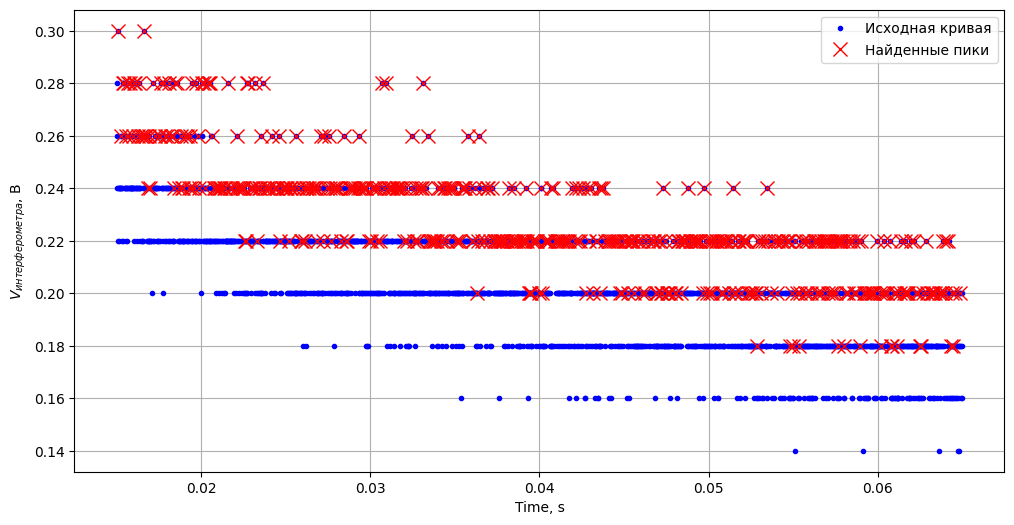

C:\Users\RedBrean\AppData\Local\Temp\ipykernel_15048\1073490752.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_data["nu"] = cut_data["Time, s"].apply(delta_nu)


In [106]:
c = 299792458
a = 1
dnu = c/(4*a)
print(dnu*1E-6, 'MHz') # частоты между пиками интерферометра

# Допустим, у нас есть массив y с значениями кривой
cut_data_wide = data[(data["Time, s"] >= 0.015) & (data["Time, s"] <= 0.065)]
cut_data = data[(data["Time, s"] >= 0.02) & (data["Time, s"] <= 0.06)]
x=cut_data_wide["Time, s"]
y=cut_data_wide["V_1"]
# Находим пики (локальные максимумы)
peaks, _ = sp.signal.find_peaks(np.array(y),   
    distance=3,          # минимум 50 точек между пиками
    prominence=0.01,       # минимальная "выдающаяся" высота
    width=1 )

# Визуализируем результат
plt.figure(figsize=(12, 6))
plt.plot(x, y, "b.", label='Исходная кривая')
plt.plot(np.array(x)[peaks], np.array(y)[peaks], "rx", markersize=10, label='Найденные пики')
peaksx = np.array(x)[peaks]
distances = peaksx*0
for i in range(len(peaksx)-1):
    distances[i] = peaksx[i+1]-peaksx[i]
print(len(distances),"\n",distances[10:15]*10000)
plt.legend()
plt.xlabel("Time, s")
plt.ylabel("$V_{интерферометра}$, В")
plt.grid(True)
plt.show()

def delta_nu(t):
    i = len(peaksx[peaksx<t])-1
    if i < 0 or i >= len(peaksx) - 1:
        raise ValueError("t вне диапазона пиков интерферометра")
    return dnu*(i + (t-peaksx[i])/(peaksx[i+1]-peaksx[i])) 

cut_data["nu"] = cut_data["Time, s"].apply(delta_nu)

